***Multiple Linear Regression model to predict house prices in Bangalore, India***



**About the File :**
Alright, so here's the deal - we're going to figure out how to predict the price of houses in Bangalore, India based on a bunch of different features. We're going to use Machine Learning algorithm to help us out. Specifically, we'll be using Linear Regression along with some other fancy techniques like Lasso and Ridge regression to make our predictions more accurate. Oh, and we'll also be using column Transformers to help us deal with all the different types of data in our dataset - like numbers and categories. It's going to be pretty cool!

We will be using the Bangaluru House Price data from Kaggle https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

[](http://)

In [369]:
import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt   
import matplotlib.style

import warnings
warnings.filterwarnings("ignore")

#LINEAR REGRESSION specific Imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [370]:
# reading the CSV file into pandas dataframe
df = pd.read_csv('/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv')

In [371]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [373]:
df.describe(include='all')

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
count,13320,13320,13319,13304,7818,13320,13247.000000,12711.000000,13320.000000
unique,4,81,1305,31,2688,2117,NaN,NaN,NaN
top,Super built-up Area,Ready To Move,Whitefield,2 BHK,GrrvaGr,1200,NaN,NaN,NaN
freq,8790,10581,540,5199,80,843,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.692610,1.584376,112.565627
std,NaN,NaN,NaN,NaN,NaN,NaN,1.341458,0.817263,148.971674
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,8.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.000000,50.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,2.000000,72.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,2.000000,120.000000


**DATA PRE-PROCESSING**

In [374]:
# Finding duplicates
df.duplicated().sum()

529

In [375]:
print('Before',df.shape)
df.drop_duplicates(inplace=True) 
print('After',df.shape)

Before (13320, 9)
After (12791, 9)


In [376]:
# Creating Lists of columns for numeric and categorical types
num_cols = [col for col in df if df.dtypes[col] != 'object']
cat_cols = [col for col in df if df.dtypes[col] == 'object']
num_cols

['bath', 'balcony', 'price']

In [377]:
cat_cols

['area_type', 'availability', 'location', 'size', 'society', 'total_sqft']

In [378]:
# unique values for categorical variables
for col in cat_cols:
    print(col.upper(),': ',df[col].nunique())
    print(df[col].value_counts().sort_values(ascending=[False]))
    print('\n')

AREA_TYPE :  4
area_type
Super built-up  Area    8317
Built-up  Area          2398
Plot  Area              1989
Carpet  Area              87
Name: count, dtype: int64


AVAILABILITY :  81
availability
Ready To Move    10172
18-May             292
18-Dec             284
18-Apr             269
18-Aug             187
                 ...  
14-Nov               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: count, Length: 81, dtype: int64


LOCATION :  1305
location
Whitefield              523
Sarjapur  Road          379
Electronic City         287
Kanakpura Road          249
Thanisandra             229
                       ... 
Richmond Road             1
Kanakapura  Rod           1
Off Bannergatta Road      1
Bhattarahalli             1
Abshot Layout             1
Name: count, Length: 1305, dtype: int64


SIZE :  31
size
2 BHK         4931
3 BHK         4120
4 Bedroom      824
4 BHK          574
3 Bedroom      535
1 BHK          521


In [379]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5328
total_sqft         0
bath              73
balcony          605
price              0
dtype: int64

In [380]:
# Dropping Society col as its having high missing values
df.drop(['society'],axis=1,inplace=True)

In [381]:
df.isna().sum()[df.isna().sum()>0]

location      1
size         16
bath         73
balcony     605
dtype: int64

In [382]:
#imputing missing values in location , balcony with mode
df['location'].fillna(df['location'].mode()[0],inplace=True)
#dropping missing values rows
df.dropna(axis=0, subset = ('size','bath','balcony'),inplace=True)

In [383]:
#dropping missing values rows
df.dropna(axis=0, subset = ('size','bath','balcony'),inplace=True)

In [384]:
df.isna().sum()[df.isna().sum()>0]
# No null values remaining

Series([], dtype: int64)

In [385]:
# Renaming col Size with bhk
df['bhk']=df['size'].str.split().str.get(0).astype(int)

In [386]:
df[df.bhk>10]

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk
459,Super built-up Area,Ready To Move,1 Giri Nagar,11 BHK,5000,9.0,3.0,360.0,11
1718,Super built-up Area,Ready To Move,2Electronic City Phase II,27 BHK,8000,27.0,0.0,230.0,27
1768,Plot Area,Ready To Move,1 Ramamurthy Nagar,11 Bedroom,1200,11.0,0.0,170.0,11
3853,Plot Area,Ready To Move,1 Annasandrapalya,11 Bedroom,1200,6.0,3.0,150.0,11
4684,Plot Area,Ready To Move,Munnekollal,43 Bedroom,2400,40.0,0.0,660.0,43
4916,Super built-up Area,Ready To Move,1Channasandra,14 BHK,1250,15.0,0.0,125.0,14
6533,Plot Area,Ready To Move,Mysore Road,12 Bedroom,2232,6.0,2.0,300.0,12
9935,Super built-up Area,Ready To Move,1Hoysalanagar,13 BHK,5425,13.0,0.0,275.0,13


In [387]:
def range_converter(x):
    temp = x.split('-')
    
    if len(temp)==2:
        return (float(temp[0])+float(temp[1]))/2
    
    try:
        return float(x)
    except:
        return None       

In [388]:
df['total_sqft']=df['total_sqft'].apply(range_converter)

In [389]:
#Adding price(in Rs) per unit area column
df['price_per_sqft']=(df['price']*100000/df['total_sqft']).round()

In [390]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3700.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4306.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6246.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.0


In [391]:
df.isnull().sum()

area_type          0
availability       0
location           0
size               0
total_sqft        42
bath               0
balcony            0
price              0
bhk                0
price_per_sqft    42
dtype: int64

In [392]:
#dropping rows with Nan to remove Null "total_sqft" value rows
df.dropna(how='any',axis=0,inplace=True)

In [393]:
df.isna().sum()

area_type         0
availability      0
location          0
size              0
total_sqft        0
bath              0
balcony           0
price             0
bhk               0
price_per_sqft    0
dtype: int64

In [394]:
# Location column has 1305 unique values. This is quite large and is not favourable for encoding.
# Hence reducing the number of unique values by combining similar values
# Removing the empty spaces in location col. and getting the value counts for each location
df['location']=df['location'].apply(lambda x:x.strip())

In [395]:
#Replacing Locations with <10 value_counts to "Others" category so as to reduce the unique count
df['location']=df['location'].apply(lambda x:'other'if x in df['location'].value_counts()[df['location'].value_counts()<=10] else x)

In [396]:
df.sample(5)

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
12642,Super built-up Area,18-Apr,Electronic City,2 BHK,1128.0,2.0,1.0,63.5,2,5629.0
6368,Super built-up Area,Ready To Move,Rayasandra,1 BHK,583.0,1.0,1.0,26.9,1,4614.0
3562,Plot Area,Ready To Move,other,4 Bedroom,1200.0,4.0,1.0,150.0,4,12500.0
7627,Super built-up Area,Ready To Move,Electronic City,2 BHK,1039.0,2.0,1.0,50.0,2,4812.0
11087,Super built-up Area,Ready To Move,other,2 BHK,1010.0,2.0,1.0,41.0,2,4059.0


In [397]:
df['location'].value_counts()
#length has reduced from 1305 to 233 with 2808 in "Others" category

location
other                   2808
Whitefield               498
Sarjapur  Road           352
Electronic City          287
Kanakpura Road           236
                        ... 
Karuna Nagar              11
Nagasandra                11
Vishveshwarya Layout      11
LB Shastri Nagar          11
Mico Layout               11
Name: count, Length: 226, dtype: int64

In [398]:
# Revisiting the Numeric Features to identify descrepencies. 
# it transpose and interchnange the row and columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_sqft,12144.0,1520.568928,1183.074391,5.0,1100.0,1265.5,1650.00,52272.0
bath,12144.0,2.630023,1.238193,1.0,2.0,2.0,3.00,40.0
balcony,12144.0,1.583663,0.822008,0.0,1.0,2.0,2.00,3.0
price,12144.0,107.522152,134.074277,8.0,50.0,70.0,115.00,2912.0
bhk,12144.0,2.748600,1.218238,1.0,2.0,3.0,3.00,43.0
price_per_sqft,12144.0,6952.093626,23108.407895,268.0,4275.5,5417.0,7228.25,2300000.0


**Identifying and Removing Outliers**

In [399]:
# ADDRESSING DISCREPENCIES 
#1. TOTAL_SQFT :The total_sqft seems to be very low in some cases
# In general an area of 350 sqft is required for 1 BHK flat. 
# Hence we drop the observations having total_sqft below 350 sqft

df.total_sqft.sort_values()

4972         5.0
349         11.0
1020        15.0
1122        24.0
5970        45.0
          ...   
12987    30400.0
674      35000.0
5469     36000.0
5393     42000.0
1894     52272.0
Name: total_sqft, Length: 12144, dtype: float64

In [400]:
# Dropping observations with total_sqft<350 sqft
df.drop(df[df['total_sqft']<350].index,inplace=True)

In [401]:
df.total_sqft.sort_values()
# all observations above 350 sqft now

3741       350.0
12464      350.0
2557       351.0
2041       360.0
8494       360.0
          ...   
12987    30400.0
674      35000.0
5469     36000.0
5393     42000.0
1894     52272.0
Name: total_sqft, Length: 12130, dtype: float64

PRICE PER SQFT 
 1894        268.0
674         371.0
5393        417.0
11748       500.0
7242        574.0
           ...   
1567      50000.0
7883      53150.0
6421      76531.0
7088      76923.0
7657     176471.0
Name: price_per_sqft, Length: 12130, dtype: float64


<Axes: >

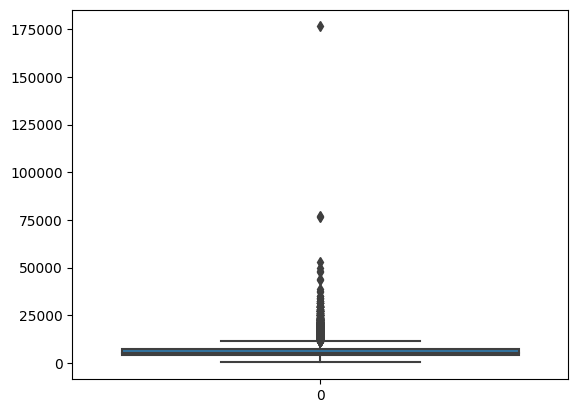

In [402]:
#2. PRICE_PER_SQFT : We observe some exhorbitent high prices that can be considered as Outliers (Check describe table above)
# We will remove the Outliers by comparing the price_per_sqft with the mean price_per_sqft of each location

print("PRICE PER SQFT",'\n',df.price_per_sqft.sort_values());
display(sns.boxplot(df['price_per_sqft']));

In [403]:
def price_outlier_treatment(data):
    df_output = pd.DataFrame()
    for key,sub_df in data.groupby('location'):
        # calculating mean and std-deviation of price_per_sqft for each location
        mean = np.mean(sub_df.price_per_sqft)
        sd = np.std(sub_df.price_per_sqft)
        # filtering the observations lying between 1.5 std-devs.
        filtered_df=sub_df[(sub_df.price_per_sqft >= (mean-1.5*sd)) & (sub_df.price_per_sqft <= (mean+1.5*sd))]
        df_output = pd.concat([df_output,filtered_df],ignore_index=True)
    return df_output

In [404]:
# Treating the outliers in the data by using the price_outlier_treatment() Function
df=price_outlier_treatment(df)
df.describe().T

# We Observe that Price/sqft has significantly reduced from 2300000 to 24000 (check describe table)
# We also observe that the minimum value for price/sqft is still quite low (268), we can reduce the std.dev (sd)
#  value to 1 to further refine the range of price/sqft.

,count,mean,std,min,25%,50%,75%,max
total_sqft,11180.0,1483.200461,1039.483315,350.0,1100.00000,1260.0,1623.0,52272.0
bath,11180.0,2.541592,1.108226,1.0,2.00000,2.0,3.0,27.0
balcony,11180.0,1.579428,0.814841,0.0,1.00000,2.0,2.0,3.0
price,11180.0,93.524602,91.540717,9.0,48.90375,68.0,104.0,2200.0
bhk,11180.0,2.658050,1.070789,1.0,2.00000,2.0,3.0,27.0
price_per_sqft,11180.0,5996.581485,2812.935776,268.0,4229.50000,5268.0,6767.0,24000.0


PRICE/SQFT after Outlier Treatment  
 8930       268.0
9624       417.0
10364      730.0
8731       730.0
11034      912.0
          ...   
42       22500.0
5298     22667.0
5285     23214.0
1802     23719.0
1811     24000.0
Name: price_per_sqft, Length: 11180, dtype: float64


<Axes: >

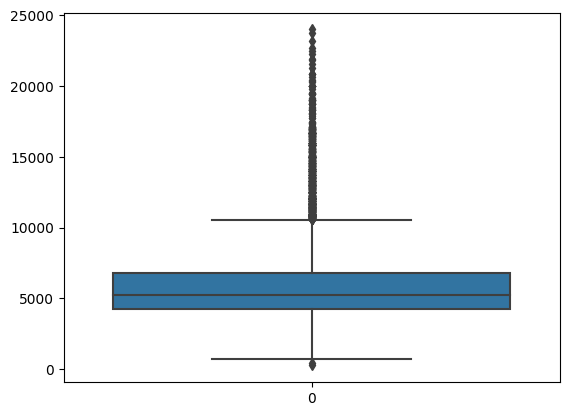

In [405]:
print("PRICE/SQFT after Outlier Treatment ",'\n',df.price_per_sqft.sort_values());
display(sns.boxplot(df['price_per_sqft']));

In [406]:
df.shape

(11180, 10)

BHK 
 9027      1
9235      1
952       1
9209      1
5282      1
         ..
9335     11
8645     11
10506    13
9539     14
8900     27
Name: bhk, Length: 11180, dtype: int64


<Axes: >

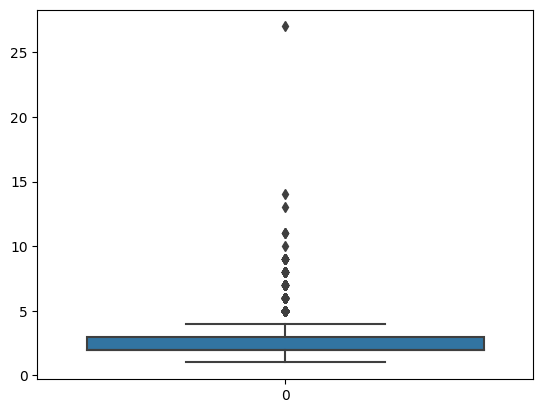

In [407]:
#3. BHK : We observe that BHK column also have some outliers with range 1 to 27 but having 3rd Quartile as 3 only.
# We will remove the Outliers by 

print("BHK","\n",df.bhk.sort_values());
display(sns.boxplot(df['bhk']));

In [408]:
def bhk_outlier_treatment(data):
    # creating an array that will store the indices that we want to exclude
    exclude_indices = np.array([])
    # Doing groupby on location to get location and location-subGroup for each location
    for location,location_df in data.groupby('location'):
        #Creating a dictionary to store bhk stats
        bhk_stats = {}
        
        #For each location-subGroup, we do groupby on bhk and get bhk and bhk-subGroup for each location-subGroup
        for bhk,bhk_df in location_df.groupby('bhk'):
            #storing mean,std-dev and count in bhk_stats
            bhk_stats[bhk] ={
                'mean':np.mean(bhk_df.price_per_sqft),
                'sd':np.std(bhk_df.price_per_sqft),
                'count':bhk_df.shape[0]
        }
        # To check the raw sub-Grouped data use below print command in the next cell code
        #print(location,bhk_df)       
        # Comparing price/sqft of any bhk-subGroup with lower bhk mean and excluding it in case mean is higher..
        for bhk,bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                # Appending exclude_indices as per the excluded bhk after above computation
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < (stats['mean'])].index.values)
    return df.drop(exclude_indices, axis='index')

In [409]:
##  observe : The lower bound of a (n)BHK will be mean of (n-1)BHK & 
#            Hence here we will keep the row if lowerbound(n)BHK > mean(n-1)BHK

df=bhk_outlier_treatment(df)


In [410]:
df.shape

(7915, 10)

In [411]:
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,20-May,1st Block Jayanagar,4 BHK,2850.0,4.0,1.0,428.0,4,15018.0
1,Super built-up Area,18-Jun,1st Block Jayanagar,3 BHK,1630.0,3.0,2.0,194.0,3,11902.0
2,Super built-up Area,17-Dec,1st Block Jayanagar,6 BHK,1200.0,6.0,2.0,125.0,6,10417.0
3,Super built-up Area,Ready To Move,1st Block Jayanagar,3 BHK,1875.0,2.0,3.0,235.0,3,12533.0
4,Super built-up Area,Ready To Move,1st Block Jayanagar,2 BHK,1000.0,3.0,2.0,60.0,2,6000.0


In [412]:
df.drop(['availability'],axis=1,inplace=True)

In [413]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price,bhk,price_per_sqft
0,Super built-up Area,1st Block Jayanagar,4 BHK,2850.0,4.0,1.0,428.0,4,15018.0
1,Super built-up Area,1st Block Jayanagar,3 BHK,1630.0,3.0,2.0,194.0,3,11902.0
2,Super built-up Area,1st Block Jayanagar,6 BHK,1200.0,6.0,2.0,125.0,6,10417.0
3,Super built-up Area,1st Block Jayanagar,3 BHK,1875.0,2.0,3.0,235.0,3,12533.0
4,Super built-up Area,1st Block Jayanagar,2 BHK,1000.0,3.0,2.0,60.0,2,6000.0


In [414]:
# df.corr()
# plt.figure(figsize = (12,9))
# sns.heatmap(df.corr(), annot = True, cmap = "magma_r")
# plt.title("Correlation Heatmap",fontdict = {"fontweight":"bold"})
# plt.show()

In [420]:
# Removing the unwanted data :
#1. Area type, Size, price_per_sqft to be dropped as they dont provide any additional info (now).

df.drop(['area_type','size','price_per_sqft','balcony'],axis=1,inplace=True)

In [421]:
df.shape

(7915, 5)

In [422]:
df.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1200.0,6.0,125.0,6
3,1st Block Jayanagar,1875.0,2.0,235.0,3
4,1st Block Jayanagar,1000.0,3.0,60.0,2


In [424]:
# Saving Cleaned data file in csv format
df.to_csv("m4_1_house_price_data_cleaned.csv")

**MODELING**

In [425]:
# Spliting the Dataset
x = df.drop(columns=['price'])
y = df['price']

In [426]:
x.shape

(7915, 4)

In [427]:
# Test- Train Split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20 , random_state=1)

In [428]:
display(X_train.shape)
display(X_test.shape)

(6332, 4)

(1583, 4)

In [429]:
X_test.head()

,location,total_sqft,bath,bhk
1000,Bannerghatta Road,1206.0,2.0,2
4773,Kereguddadahalli,1105.0,2.0,2
2323,Electronic City Phase II,975.0,2.0,3
7027,TC Palaya,1200.0,2.0,2
8916,other,1494.0,2.0,3


In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7915 entries, 0 to 11177
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    7915 non-null   object 
 1   total_sqft  7915 non-null   float64
 2   bath        7915 non-null   float64
 3   price       7915 non-null   float64
 4   bhk         7915 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 371.0+ KB


In [431]:
df['bhk'] = df ['bhk'].astype ('float64')

**Applying Linear Regression**

In [432]:
# Using Column_transformation for categorical Features (Ready_to_move and location)
col_trans = make_column_transformer((OneHotEncoder(sparse=False),['location']),remainder='passthrough')

In [433]:
scaler = StandardScaler()

In [435]:
lr = LinearRegression()

In [436]:
pipe = make_pipeline(col_trans,scaler,lr)

In [437]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['location'])])),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [438]:
y_pred_lr = pipe.predict(X_test)

In [439]:
r2_score(y_test,y_pred_lr)

0.7258082723675382

**Applying Lasso regression**

In [441]:
lasso=Lasso()

In [442]:
pipe = make_pipeline(col_trans,scaler,lasso)


In [443]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['location'])])),
                ('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [444]:
y_pred_lasso = pipe.predict(X_test)
r2_score(y_test,y_pred_lasso)

0.7143515593082206

**Applying Ridge regression**

In [445]:
ridge=Ridge()
pipe = make_pipeline(col_trans,scaler,ridge)
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(sparse=False),
                                                  ['location'])])),
                ('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [446]:
y_pred_ridge = pipe.predict(X_test)
r2_score(y_test,y_pred_ridge)

0.7258426570951946

In [447]:
print("Linear Regression",r2_score(y_test,y_pred_lr))
print("Lasso",r2_score(y_test,y_pred_lasso))
print("Ridge",r2_score(y_test,y_pred_ridge))

Linear Regression 0.7258082723675382
Lasso 0.7143515593082206
Ridge 0.7258426570951946


In [448]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7915 entries, 0 to 11177
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    7915 non-null   object 
 1   total_sqft  7915 non-null   float64
 2   bath        7915 non-null   float64
 3   price       7915 non-null   float64
 4   bhk         7915 non-null   float64
dtypes: float64(4), object(1)
memory usage: 371.0+ KB


**Convert to Pickle file for model deployment**

In [449]:
import pickle
pickle.dump(pipe,open('RidgeModel_4_1.pkl','wb'))